In [30]:
# define minimal uncorrelated sample for 3 variables

import pandas as pd
import numpy as np


data = pd.DataFrame(
    {"x": np.array([0,0,0,0,1,1,1,1]),
     "y": np.array([0,0,1,1,0,0,1,1]),
     "z": np.array([0,1,0,1,0,1,0,1])
    }
).replace({0: -1})

data

,x,y,z
0,-1,-1,-1
1,-1,-1,1
2,-1,1,-1
3,-1,1,1
4,1,-1,-1
5,1,-1,1
6,1,1,-1
7,1,1,1


We are interested in building a model where we have shap values of zero because of negative values of the game. 

We define our sample as above, with $E(X) = E(Y) = E(Z) = 0$ and $E[f(x,y,z)] = 0$ for simplicity.

Let's define

$$f(x) = x-2xy-2xz+3xyz$$

so that for (-1,1,1) we have shap values (0,0,0).

In [31]:
data["f"] = data.x - 2*data.y*data.x - 2*data.z*data.x + 3*data.y*data.z*data.x
data

,x,y,z,f
0,-1,-1,-1,-8
1,-1,-1,1,2
2,-1,1,-1,2
3,-1,1,1,0
4,1,-1,-1,8
5,1,-1,1,-2
6,1,1,-1,-2
7,1,1,1,0


In [9]:
# train (overfit) decision tree
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(data[["x", "y", "z"]], data.f)
tree.score(data[["x", "y", "z"]], data.f) # we want a perfect fit here for demo

1.0

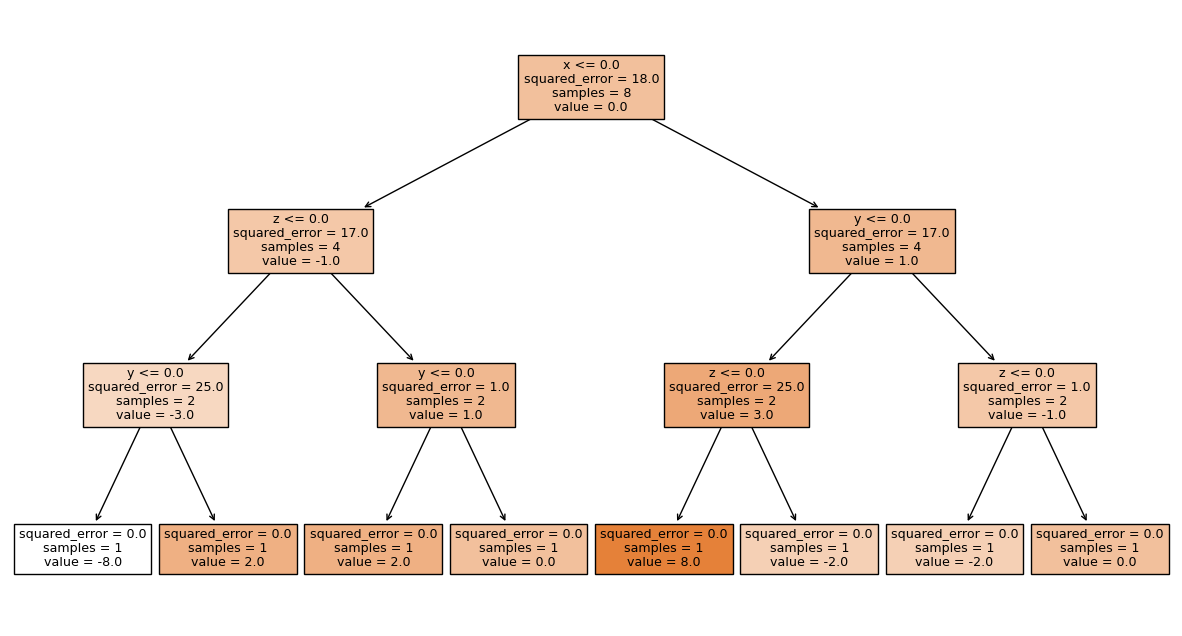

In [14]:
# visualize tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15,8))
plot_tree(tree, feature_names=["x", "y", "z"], filled=True)
plt.show()


In [20]:
# compute shap values

from shap.explainers import TreeExplainer

tE = TreeExplainer(tree, feature_perturbation="interventional", model_output="raw")

In [32]:
sv = tE.shap_values(data[["x", "y", "z"]])
sv.round(2)

array([[-4., -2., -2.],
       [ 0.,  0.,  2.],
       [ 0.,  2.,  0.],
       [ 0., -0., -0.],
       [ 4.,  2.,  2.],
       [-0., -0., -2.],
       [-0., -2., -0.],
       [ 0.,  0.,  0.]])

In [33]:
sv_df = pd.DataFrame(sv.round(2), columns=["x_shap", "y_shap", "z_shap"])

# join to data
data = data.join(sv_df)
data

,x,y,z,f,x_shap,y_shap,z_shap
0,-1,-1,-1,-8,-4.0,-2.0,-2.0
1,-1,-1,1,2,0.0,0.0,2.0
2,-1,1,-1,2,0.0,2.0,0.0
3,-1,1,1,0,0.0,-0.0,-0.0
4,1,-1,-1,8,4.0,2.0,2.0
5,1,-1,1,-2,-0.0,-0.0,-2.0
6,1,1,-1,-2,-0.0,-2.0,-0.0
7,1,1,1,0,0.0,0.0,0.0


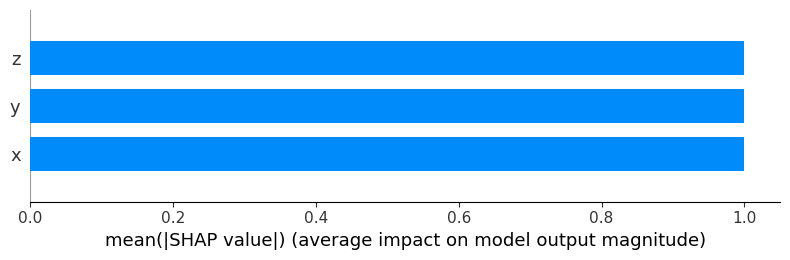

In [36]:
# plot overall shap importance

import shap

shap.summary_plot(sv, data[["x", "y", "z"]], plot_type="bar")

The split count attribution would instead have been (1,3,3) for (x,y,z), which shows how it can be misleading.